In [230]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import train
from random import shuffle
import imp
%matplotlib inline

In [4]:
characters = [k.split('/')[2] for k in glob.glob('./characters/*') if len([p for p in glob.glob(k+'/*') 
                                                                           if 'edited' in p or 'pic_vid' in p]) > 300]
map_characters = dict(enumerate(characters))
print(map_characters)

{0: 'abraham_grampa_simpson', 1: 'bart_simpson', 2: 'charles_montgomery_burns', 3: 'homer_simpson', 4: 'krusty_the_clown', 5: 'lisa_simpson', 6: 'marge_simpson', 7: 'moe_szyslak', 8: 'ned_flanders', 9: 'sideshow_bob'}


In [246]:
imp.reload(train)
## Just creating dataset
X_train, X_test, y_train, y_test = train.get_dataset(save=True)

Train (7694, 64, 64, 3) (7694, 10)
Test (1358, 64, 64, 3) (1358, 10)
marge_simpson : 1009 train pictures & 167 test pictures
homer_simpson : 1005 train pictures & 171 test pictures
bart_simpson : 997 train pictures & 179 test pictures
lisa_simpson : 988 train pictures & 188 test pictures
moe_szyslak : 984 train pictures & 171 test pictures
charles_montgomery_burns : 690 train pictures & 135 test pictures
ned_flanders : 604 train pictures & 102 test pictures
krusty_the_clown : 528 train pictures & 92 test pictures
abraham_grampa_simpson : 509 train pictures & 86 test pictures
sideshow_bob : 380 train pictures & 67 test pictures


#### Four convulational layers

##### Same pictures training/testing

In [250]:
## Training in the notebook
# X_train, X_test, y_train, y_test = train.get_dataset()
# model, opt = train.create_model(X_train.shape[1:])
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model, history = train.training(model, X_train, X_test, y_train, y_test, data_augmentation=True)

## Training on AWS
# X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('./models/model_05-06.h5')
with open('./models/history_05_06.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.88      0.94      0.91        86
            bart_simpson       0.82      0.89      0.85       179
charles_montgomery_burns       0.97      0.78      0.86       135
           homer_simpson       0.80      0.94      0.86       171
        krusty_the_clown       0.99      0.96      0.97        92
            lisa_simpson       0.88      0.90      0.89       188
           marge_simpson       1.00      0.95      0.98       167
             moe_szyslak       0.94      0.91      0.93       171
            ned_flanders       0.97      0.92      0.94       102
            sideshow_bob       0.95      0.87      0.91        67

             avg / total       0.91      0.91      0.91      1358



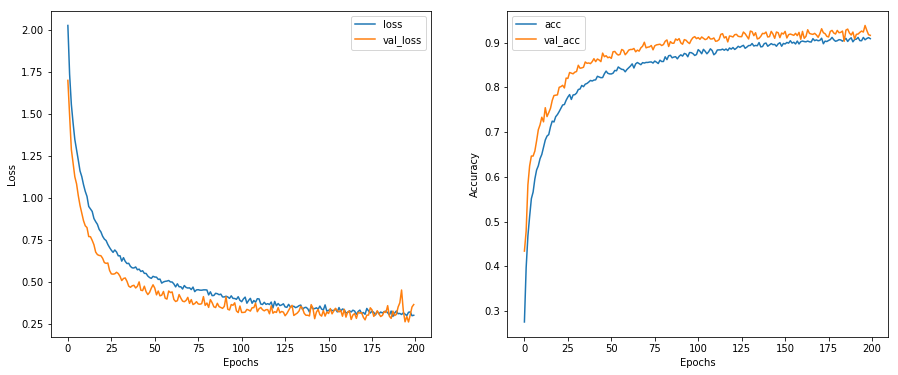

In [210]:
epochs= range(200)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

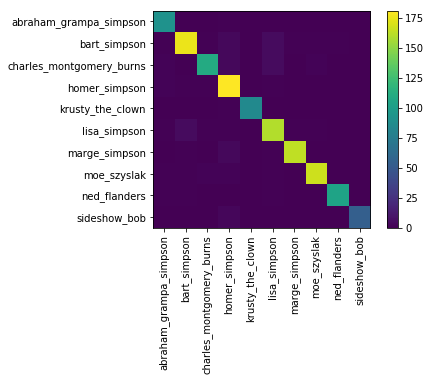

In [211]:
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

##### With BGR/RGB

In [249]:
X_test2 = []
for img in X_test:
    X_test2.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
X_test2 = np.array(X_test2)
model = keras.models.load_model('./models/model_BGR.h5')
y_pred = model.predict(X_test2)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.86      0.95      0.91        86
            bart_simpson       0.95      0.82      0.88       179
charles_montgomery_burns       0.93      0.86      0.89       135
           homer_simpson       0.88      0.90      0.89       171
        krusty_the_clown       0.94      0.97      0.95        92
            lisa_simpson       0.85      0.94      0.89       188
           marge_simpson       0.99      0.97      0.98       167
             moe_szyslak       0.94      0.95      0.94       171
            ned_flanders       1.00      0.92      0.96       102
            sideshow_bob       0.86      0.97      0.91        67

             avg / total       0.92      0.92      0.92      1358



#### Six convolutional layers 

In [19]:
## Training on AWS
X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('./models/model_sixconv.h5')
with open('./models/history2.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (6893, 64, 64, 3) (6893, 10)
Test (766, 64, 64, 3) (766, 10)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.95      0.94        58
            bart_simpson       0.83      0.89      0.86        89
charles_montgomery_burns       0.87      0.68      0.76        76
           homer_simpson       0.90      0.94      0.92       147
        krusty_the_clown       0.91      0.98      0.94        41
            lisa_simpson       0.90      0.85      0.87       102
           marge_simpson       0.96      0.95      0.96       108
             moe_szyslak       0.80      0.89      0.84        45
            ned_flanders       0.93      0.86      0.89        59
            sideshow_bob       0.84      0.93      0.88        41

             avg / total       0.89      0.89      0.89       766



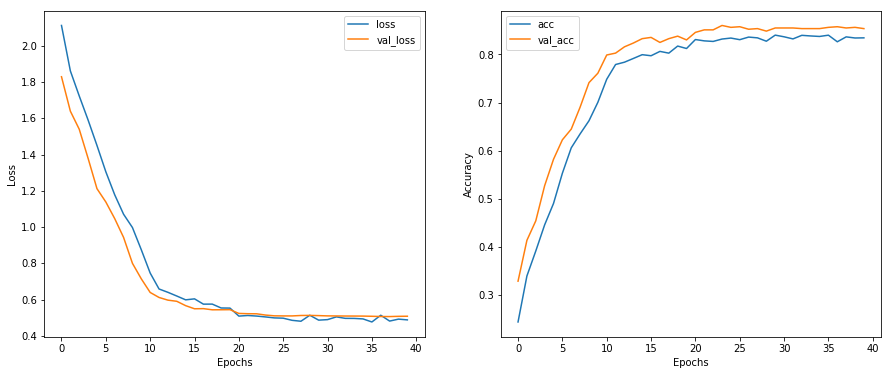

In [21]:
epochs= range(40)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [22]:
## -> More overfitting

#### Predict from url

In [340]:
import urllib
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict_proba(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

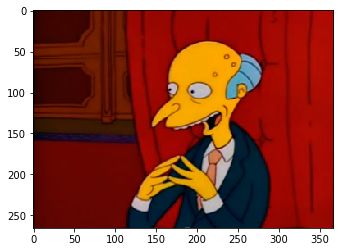

1/1 [==============================] - 0s


'Charles Montgomery Burns'

In [345]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
plot_and_predict(url)

#### Generating and plotting

6/9


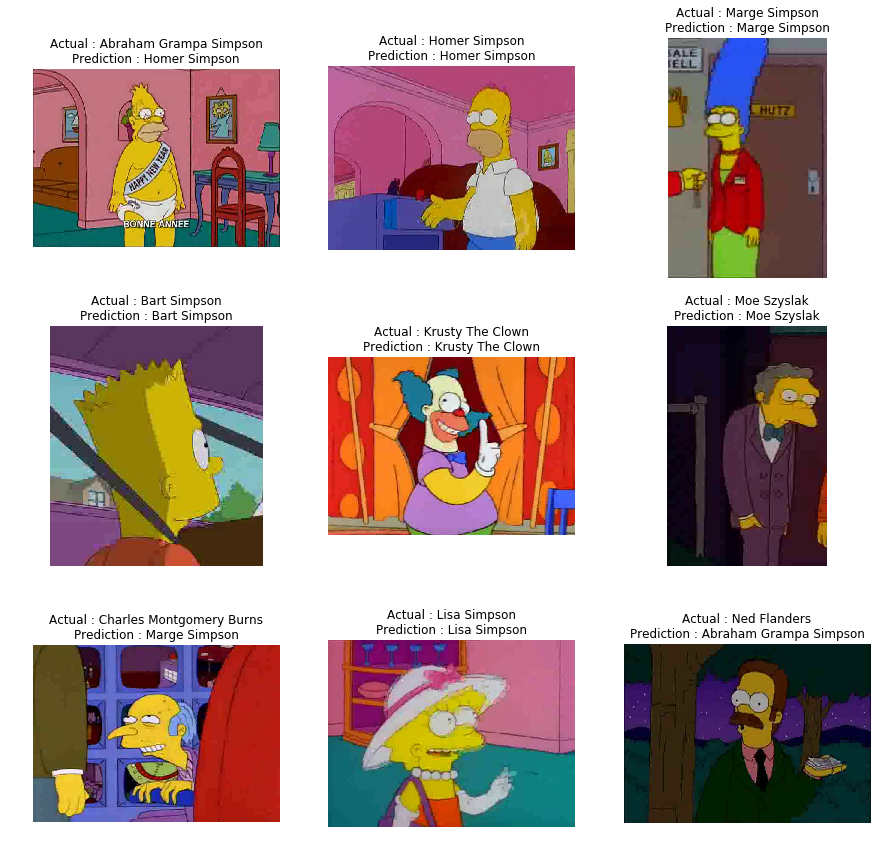

In [228]:
pic_size = 64
f, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
#plt.subplots_adjust( wspace=0.1, hspace=0.05)
corr = 0
for i, char in enumerate(list({0: 'abraham_grampa_simpson', 1: 'bart_simpson', 
                  2: 'charles_montgomery_burns', 3: 'homer_simpson', 4: 'krusty_the_clown',
                  5: 'lisa_simpson', 6: 'marge_simpson', 7: 'moe_szyslak', 
                  8: 'ned_flanders', 9: 'sideshow_bob'}.values())[:-1]):
    image = cv2.imread(np.random.choice([k for k in glob.glob('./characters/%s/*' % char) if 'pic_vid' in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i%3, i//3].imshow(img)
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict(pic.reshape(1, pic_size, pic_size,3))
    actual = char.replace('_',' ').title()
    pred = map_characters[np.argmax(a)].replace('_',' ').title()
    ax[i%3, i//3].set_title('Actual : %s\nPrediction : %s' % (actual,pred))
    ax[i%3, i//3].axis('off')
    corr += actual == pred
print('%d/9'%corr)

#### Attention maps

Working on filters: [3]
homer_simpson
Working on filters: [1]
bart_simpson
Working on filters: [2]
charles_montgomery_burns
Working on filters: [1]
bart_simpson
Working on filters: [1]
bart_simpson


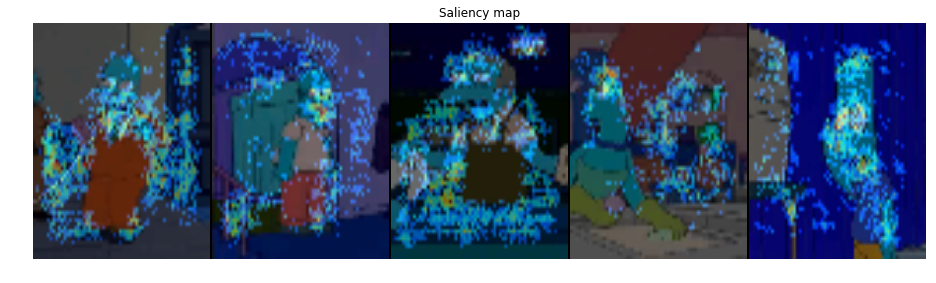

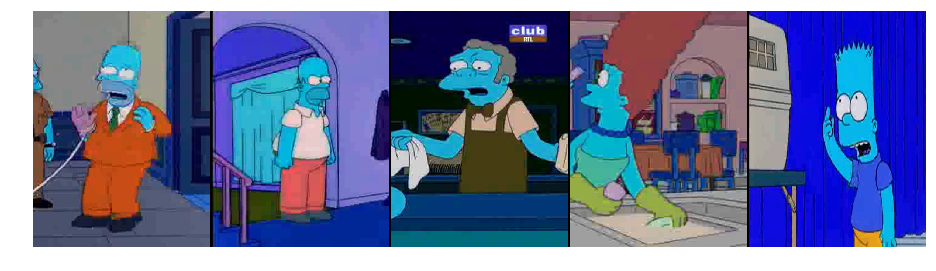

In [178]:
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_saliency

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_idx = [idx for idx, layer in enumerate(model.layers)][16]

# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = [
    './characters/homer_simpson/pic_video10_54.jpg',
    './characters/homer_simpson/pic_video6_1881.jpg',
    './characters/moe_szyslak/pic_video5_8780.jpg',
    './characters/marge_simpson/pic_video6_49.jpg',
    './characters/bart_simpson/pic_video0_460.jpg',
]

heatmaps = []
true_img = []
for path in image_paths:
    seed_img1 = cv2.imread(path)
    seed_img = np.reshape(cv2.resize(seed_img1, (64,64)),(1,64,64,3))
    pred_class = np.argmax(model.predict(seed_img))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    heatmap = visualize_saliency(model, layer_idx, [pred_class], seed_img)
    heatmaps.append(cv2.resize(heatmap, (480,640))) 
    true_img.append(cv2.resize(seed_img1,(480,640)))
    print(map_characters[pred_class])

plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(utils.stitch_images(heatmaps))
plt.title('Saliency map')
plt.show()

plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(utils.stitch_images(true_img))
plt.show()